In [2]:
import pandas as pd # used to read the csv
import csv          # used to read the csv
import matplotlib.pyplot as plt
import math
import numpy as np
import random

plt.rcParams["figure.figsize"] = (13,9) # To change plot size

# Constants

In [92]:
DEBUG = False
VERBOSE_PARTICLE = False # to print infos messages

# Map things
MAP_REAL = [841*2,1189] # [mm] (x,y dimensions of the map, here 2*A0)
FEATURE2PROX_L = {'grass' : 460,
                  'road' : 600,
                  'crossing' : 945}
FEATURE2PROX_R = {'grass' : 230,
                  'road' : 300,
                  'crossing' : 700}

# The same for any robot
THYMIO_WHEELBASE = 95 # [mm]
THYMIO_SHAPE =  [[ 55.0, -30.0, -30.0,  55.0,  80.0,  55.0],
                 [-47.5, -47.5,  47.5,  47.5,   0.0, -47.5]]
                # [mm] Shape of the thymio robot, for plots
PROX_POS = [[72,72], [13,-13]] # [mm] (x,y coords of the prox sensors)
WEIGHT_RESAMPLE_THRSH = 0.001
ISLOST_THRSH = 10 # [mm] max standard deviation allowed

# To tune for a robot
SPEED_L_STD = 10 # [thymio units]
SPEED_R_STD = 10 # [thymio units]
SPEED_CONVERSION_FACTOR = 1/200 # [from thymio units to mm/ms]
PROX_L_STD = 10 # [thymio units]
PROX_R_STD = 10 # [thymio units]

# Thymio data aquisition
May be useful to set the constants

In [1]:
TRSH_DT = 0.2 # treshold on the derivative, to find the edges on map
SCALE_DT = 1000 # scaling to display dt and normal on the same plot

tele = pd.read_csv('read.csv', low_memory=False)

tele = tele.rename(columns = {' m[0] ' : "speed", 
                                        ' m[1] ' : "ground",
                                        ' "timestamp"' : "time"})

# Derivative with respect to time
time_step = tele['time'][1] - tele['time'][0]

tele["ground_dt"] = tele["ground"]
tele["ground_dt"][0] = 0

tele["ground_dt"][1:len(tele['time'])] = [(tele["ground"][i] - tele["ground"][i-1])/time_step for i in range(1, len(tele['time']))]


# plot
plt.plot(tele.time, tele.ground, label='Ground')
plt.plot(tele.time, SCALE_DT*tele.ground_dt, label='Ground derivative')
plt.hlines(SCALE_DT*TRSH_DT, 0, max(tele.time), linestyles='dashed', color='red', label="threshold value")
plt.hlines(-SCALE_DT*TRSH_DT, 0, max(tele.time), linestyles='dashed', color='red', label="threshold value")

plt.xlabel("Time [s]")
plt.ylabel("Value")

plt.show()

NameError: name 'pd' is not defined

Standard deviation at speed 100 : Left 8.193	Right 6.17
Mean at speed 100 : Left 100.758	Right 98.818


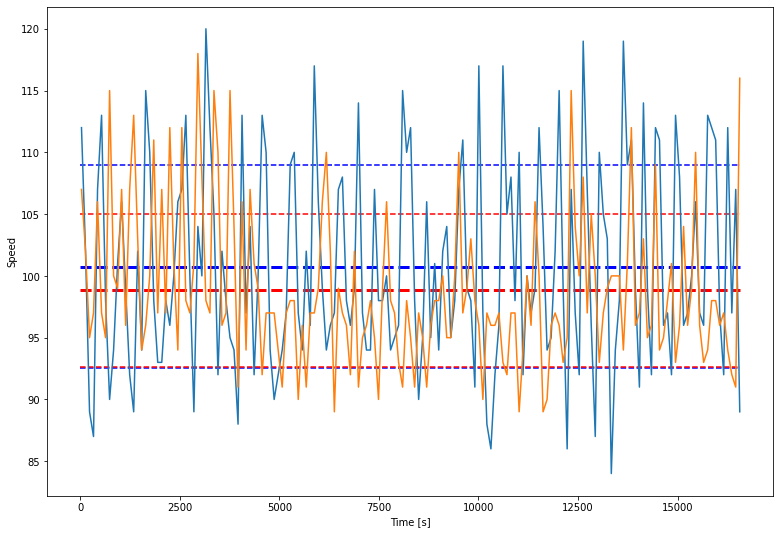

In [4]:
# Check motor noise
speed = '100'

tele = pd.read_csv('speed' +speed+'.csv', low_memory=False)

tele = tele.rename(columns = {' m[0] ' : "left", 
                            ' m[1] ' : "right",
                            ' "timestamp"' : "time"})


# plot
print(f"Standard deviation at speed {speed} : Left {round(np.std(tele.left),3)}\tRight {round(np.std(tele.right),3)}")
print(f"Mean at speed {speed} : Left {round(np.mean(tele.left),3)}\tRight {round(np.mean(tele.right),3)}")

plt.plot(tele.time, tele.left, label='left')
plt.plot(tele.time, tele.right, label='right')
plt.hlines(np.mean(tele.left), 0, max(tele.time), linestyles='dashed', color='blue', linewidth=3)
plt.hlines(np.mean(tele.left)+np.std(tele.left), 0, max(tele.time), linestyles='dashed', color='blue')
plt.hlines(np.mean(tele.left)-np.std(tele.left), 0, max(tele.time), linestyles='dashed', color='blue')
plt.hlines(np.mean(tele.right), 0, max(tele.time), linestyles='dashed', color='red', linewidth=3)
plt.hlines(np.mean(tele.right)+np.std(tele.right), 0, max(tele.time), linestyles='dashed', color='red')
plt.hlines(np.mean(tele.right)-np.std(tele.right), 0, max(tele.time), linestyles='dashed', color='red')

plt.xlabel("Time [s]")
plt.ylabel("Speed")

plt.show()

# Map example
given by Nathan

In [4]:
file_CSV = open('output/roads.csv')
reader = csv.reader(file_CSV)
roads = list(reader)

file_CSV = open('output/passage.csv')
reader = csv.reader(file_CSV)
passage = list(reader)

myMap = {'road': roads,
         'crossing': passage}

In [50]:
def mm2map(coord,map_shape):
    '''
    Converts the coord from mm to map coordinates.
    map_shape = [max_x, max_y]
    '''
    return [int(coord[i]/MAP_REAL[i]*map_shape[i]) for i in range(len(coord))]


def expected_prox(*args, **kwargs):
    '''
    Computes the expected prox values for a point (in mm) on the map.
    
    Arguments:
    - dict of floats {'x':x, 'y':y, 'theta':theta} OR 3 floats x, y, theta
    '''    
    # Extract the points of interest (POI)
    loc = Moving_point(*args).get_coords()
    pts = range(len(PROX_POS[0]))
    #    rotate the shape
    POI_x = [PROX_POS[0][i]*math.cos(loc['theta']) - PROX_POS[1][i]*math.sin(loc['theta']) for i in pts]
    POI_y = [PROX_POS[0][i]*math.sin(loc['theta']) + PROX_POS[1][i]*math.cos(loc['theta']) for i in pts]
    #    shift the shape
    POI_x = [POI_x[i] + loc['x'] for i in pts]
    POI_y = [POI_y[i] + loc['y'] for i in pts]
    
    # Determine what kind of feature is at the POI
    myMap_max = [len(myMap['road']), len(myMap['road'][0])]
    POI_map = [mm2map([POI_x[i], POI_y[i]], myMap_max) for i in range(2)]
    feature = ['grass', 'grass']
    for i in pts:
        idx_x = POI_map[i][0]
        idx_y = POI_map[i][1]
        if idx_x >= myMap_max[0] or idx_x < 0 or idx_y >= myMap_max[1] or idx_y < 0:
            idx_x %= myMap_max[0]
            idx_y %= myMap_max[1]
            print('Warning : Robot (or Particle) ground sensors are out of the map !')
            print('\tContinue working as if the map repeats.')
            
        if myMap['road'][idx_x][idx_y] == 1:
            feature[i] = 'road'
        elif myMap['crossing'][idx_x][idx_y] == 1:
            feature[i] = 'crossing'
        else:
            feature[i] = 'grass'
            
    # Associate the feature to a prox value
    expected_prox = [FEATURE2PROX_L[feature[0]], FEATURE2PROX_R[feature[1]]]
    
    
    return expected_prox

# Localisation code
## Class and functions definition
The maths for the odometry from the wheels speeds is taken from the book "Elements of Robotics" by Mordechai Ben-Ari and Francesco Mondada.
###  Base class (Moving_point)
This class is used to define only once the fuctions for the evolution of a 2 wheeled robot.

In [5]:
class Moving_point:
    '''
    One moving point having the same dynamics as the robot.
    The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] horizontal coordinate of the point. (mm)
    -y: [float] vertical coordinate of the point. (mm)
    -theta: [float] orientation of the point (theta == 0 <=> looks at +x). (rad)
    '''
    def __init__(self, *args, **kwargs):
        # -- Public --
        self.set_coords(*args)
        return     
        
       
    def __repr__(self):
        r = "Current position:\n"
        r += f"x = \t\t{round(self.x,2)}\n" 
        r += f"y = \t\t{round(self.y,2)}\n"
        r += f"theta = \t{round(self.theta,2)}\n"
        return r
    
    
    def get_coords(self):
        '''
        Get the coords as a dict {'x':x, 'y':y, 'theta':theta}.
        
        Arguments:
        - void
        
        Outputs:
        - dict of floats {'x':x, 'y':y, 'theta':theta}
        '''
        return {'x':self.x, 'y':self.y, 'theta':self.theta}
    
    
    def set_coords(self, *args, **kwargs):
        '''
        Set the coordinates.
        
        Arguments:
        - dict of floats {'x':x, 'y':y, 'theta':theta} OR 3 floats x, y, theta
        
        Outputs:
        - void
        '''
        if len(args) == 3:
            self.x = args[0]
            self.y = args[1]
            self.theta = args[2]
        elif len(args) == 1 and type(*args) == dict:
            self.x = args[0]['x']
            self.y = args[0]['y']
            self.theta = args[0]['theta'] 
        else:
            print("Error: Coordiantes must be set either with a dict or with x, y and theta.")
        return
      
    
    def _speed2mmpms(self, speed):
        '''
        Convert Thymio speed into mm/ms.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R], in Thymio units
        
        Output:
        - speed: list of both wheelspeeds [speed_L, speed_R], in mm/ms
        '''
        return [speed[0]*SPEED_CONVERSION_FACTOR, speed[1]*SPEED_CONVERSION_FACTOR]
    
    
    def _apriori_odometry(self, speed, dt):
        speed = self._speed2mmpms(speed)
        dl = speed[0]*dt
        dr = speed[1]*dt
        
        dtheta = (dr-dl)/THYMIO_WHEELBASE
        dc = (dl+dr)/2
        
        self.x += dc*math.cos(self.theta + dtheta/2)
        self.y += dc*math.sin(self.theta + dtheta/2)
        self.theta += dtheta
        self.theta %= 2*math.pi
        return

### Particle filter
The particle class should not be used/accessed outside of this module.
A small library exists [here](https://filterpy.readthedocs.io/en/latest/monte_carlo/resampling.html). A tutorial is [here](https://salzis.wordpress.com/2015/05/25/particle-filters-with-python/). Also, [this YouTube video](https://www.youtube.com/watch?v=aUkBa1zMKv4&ab_channel=AndreasSvensson) explains the principle of the filter.

Pseudocode :
```python
def PARTICLE_FILTERING(e, N, dbn):
    '''
    Short: returns a set of samples for the next time step
    
    inputs: 
    - e, the new incoming evidence
    - N, the number of samples to be maintained
    - dbn, a Dynamic Bayesian Network with prior P(X0), transition model P(X1 | X0), sensor model P(E1 | X1)

    persistent:
    - S, a vector of samples of size N, initially generated from P(X0)

    local variables: 
    - W, a vector of weights of size N
    '''
    for i in range(N):
        # step 1: Transition for each particle
        S[i] = sample from P(X1 | X0 = S[i])

        # step 2: Assign weight to particles given the measurement
        W[i] = P(e | X1 = S[i])

        # step 3: Resample the particles
        S = WEIGHTED-SAMPLE-WITH-REPLACEMENT(N, S, W)
    return S
```

In [31]:
class Particle(Moving_point):
    '''
    One particle representing the robot. The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] horizontal coordinate of the robot. (mm)
    -y: [float] vertical coordinate of the robot. (mm)
    -theta: [float] orientation of the robot (theta == 0 <=> looks at +x). (rad)
    '''
    _w_max = 0
    
    def __init__(self, *args, **kwargs):
        # -- Public --
        super().__init__(*args)
            
        self.w = 1 # weight of the particle
        
    
    def reset_total_weight():
        '''
        Resets the total weight.
        '''
        Particle._w_sum = 0
        Particle._w_max = 0
    
    
    def get_weight(self):
        '''
        Get the weight.
        
        Arguments:
        - void
        
        Outputs:
        - weight (float)
        '''
        return self.w
    
    
    def set_weight(self, weight):
        '''
        Set the weight.
        
        Arguments:
        - weight (float)
        
        Outputs:
        - void
        '''
        self.w = weight
        return
    
    
    def transition(self, speed, dt):
        '''
        Updates the particle from the measured motor speeds.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R]
        - dt: float, time interval between each update, in ms
        
        Output:
        -void
        '''
        if VERBOSE_PARTICLE:
            print("Particle pose is getting updated ...")
        
        # Checking correcti dimensions of the args
        try:
            speed_not_ok = len(speed) != 2
        except:
            speed_not_ok = True
        if speed_not_ok:
            print("'speed' argument is of incorrect type/size.")
            print("\tspeed: list of both wheelspeeds [speed_L, speed_R]")
            return
        if type(dt) != int and type(dt) != float:
            print("'dt' argument is of incorrect type/size.")
            print("\tdt: float, time interval between each update, in ms")
            return
        
        # Add gaussian noise to the speeds
        speed[0] += random.gauss(0, SPEED_L_STD)
        speed[1] += random.gauss(0, SPEED_R_STD)
        
        # Do the transition
        self._apriori_odometry(speed, dt)

        
        # Print infos for debugging
        if VERBOSE_PARTICLE:
            print(f"The speeds are : {self._speed2mmps(speed)}")
            print(f"The particle is at : {self}")
            print("Particle pose has been updated successfully !\n")
        return
    
    
    def weight(self, prox):
        '''
        Updates the particle's weight from the measured ground value.
        The weight computed here is not normalised.
        The weight is the likelyhood of the measured prox w.r.t. the expected prox.

        Arguments:
        - prox: list of both ground proximity sensors (delta) [prox_L, prox_R]
        - dt: float, time interval between each update, in ms

        Output:
        -void
        '''
        # Compute weight (assume the prox noise is gaussian)
        mp = np.array(prox) # measured prox
        ep = np.array(expected_prox(self.get_coords())) # expected prox
        dp = mp-ep
        self.w = math.exp(-(dp[0]**2/PROX_L_STD + dp[1]**2/PROX_R_STD)/2)        
        
        # Update weight sum
        Particle._w_sum += self.w
        
        # Update max weight
        if self.w > Particle._w_max:
            Particle._w_max = self.w
        return
    
    
    def plot(self, plot_theta=True):
        SCALING_THETAS_PLOT = 1

        # Creating end point to plot theta
        theta_dx = SCALING_THETAS_PLOT*math.cos(self.theta)
        theta_dy = SCALING_THETAS_PLOT*math.sin(self.theta)

        # Plotting the circle
        if Particle._w_max > 1e-15: # to avoid division by zero  
            plt.scatter(self.x, self.y, marker='.', s=300*(self.w/Particle._w_max), alpha=0.3)
        else:
            plt.scatter(self.x, self.y, marker='.', s=300*(0.1), alpha=0.3)

        # Plotting theta arrow
        if plot_theta:
            plt.arrow(self.x, self.y, theta_dx, theta_dy, width=0.1, head_width=1, alpha=0.2)

        return

### Pose of the robot
The pose of the robot is the interface for the global code.

In [85]:
class Pose(Moving_point):
    '''
    Class for the pose of the robot. The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] Most probable horizontal coordinate of the robot. (mm)
    -y: [float] Most probable vertical coordinate of the robot. (mm)
    -theta: [float] Most probable orientation of the robot (theta == 0 <=> looks at +x). (rad)
    -isLost: [bool] If the localisation gets too imprecise, isLost == True
    '''
    def __init__(self, x, y, theta, isLost=False, nb_particles=100):
        # -- Public --
        super().__init__(x, y, theta)
        self.isLost = isLost
        
        # Initialisation of the particle filter
        self._particles = []
        self._weights = []

        for i in range(nb_particles):
            myParticle = Particle(self.get_coords())
            self._particles.append(myParticle.get_coords())
            self._weights.append(myParticle.get_weight())
        
     
    def update(self, speed, prox, dt):
        '''
        Updates the pose from the displacement and sensors values.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R]
        - prox: list of both ground.delta [prox_1, prox_2]
        - dt: float, time interval between each update, in ms
        
        Output:
        -void
        '''
        if DEBUG:
            print("Pose is getting updated ...")
        
        # Checking correcti dimensions of the args
        try:
            speed_not_ok = len(speed) != 2
            prox_not_ok = len(prox) != 2
        except:
            speed_not_ok = True
            prox_not_ok = True
        if speed_not_ok:
            print("'speed' argument is of incorrect type/size.")
            print("\tspeed: list of both wheelspeeds [speed_L, speed_R]")
            return
        if prox_not_ok:
            print("'prox' argument is of incorrect type/size.")
            print("\tprox: list of both ground.delta [prox_1, prox_2]")
            return
        if type(dt) != int and type(dt) != float:
            print("'dt' argument is of incorrect type/size.")
            print("\tdt: float, time interval between each update, in ms")
            return
        
        # Do update using coord
        self._apriori_odometry(speed, dt)
        
        # Update particles
        self._update_particles(speed, prox, dt)
        
        # Update position from the particles (weighted average of the particle)
        xs = [self._particles[i]['x'] for i in range(len(self._particles))]
        xs = np.array(xs)
        ys = [self._particles[i]['y'] for i in range(len(self._particles))]
        ys = np.array(ys)
        thetas = [self._particles[i]['theta'] for i in range(len(self._particles))]
        thetas = np.array(thetas)
        
        self.x = np.sum(xs*np.array(self._weights)) / sum(self._weights)
        self.y = np.sum(ys*np.array(self._weights)) / sum(self._weights)
        self.theta = np.sum(thetas*np.array(self._weights)) / sum(self._weights)
        
        # Check if lost
        distance_to_particles = [math.sqrt(xs[i]**2 + ys[i]**2) for i in range(len(self._particles))]
        if np.std(distance_to_particles) >= ISLOST_THRSH:
            self.isLost = True
        else:
            self.isLost = False
        
        # Print infos for debugging
        if DEBUG:
            print(f"The speeds are : {self._speed2mmps(speed)}")
            print(f"The prox are : {prox}")
            print("Pose has been updated successfully !\n")
        return
    
    
    def plot(self, plot_theta=True, theta_size=1, plot_particles=True):
        '''
        Plots the current pose and the particles.
        '''
        # Plotting the particles
        if plot_particles:
            for i in range(len(self._particles)):
                myParticle = Particle(self._particles[i])
                myParticle.set_weight(self._weights[i])
                myParticle.plot(plot_theta=plot_theta)
        
        # Creating end points to plot thetas
        theta_dx = theta_size*math.cos(self.theta)
        theta_dy = theta_size*math.sin(self.theta)

        # Plotting the pose of the thymio
        pts = range(len(THYMIO_SHAPE[0]))
        #    rotate the shape
        thy_x = [THYMIO_SHAPE[0][i]*math.cos(self.theta) - THYMIO_SHAPE[1][i]*math.sin(self.theta) for i in pts]
        thy_y = [THYMIO_SHAPE[0][i]*math.sin(self.theta) + THYMIO_SHAPE[1][i]*math.cos(self.theta) for i in pts]
        #    shift the shape
        thy_x = [thy_x[i] + self.x for i in pts]
        thy_y = [thy_y[i] + self.y for i in pts]
        if self.isLost:
            plt.scatter(self.x, self.y, marker='o', color='red', s=100)
            plt.plot(thy_x, thy_y, color='red')
        else:
            plt.scatter(self.x, self.y, marker='o', color='green', s=100)
            plt.plot(thy_x, thy_y, color='green')
            
        # Plotting the prox locations
        pts = range(len(PROX_POS[0]))
        #    rotate the shape
        thy_x = [PROX_POS[0][i]*math.cos(self.theta) - PROX_POS[1][i]*math.sin(self.theta) for i in pts]
        thy_y = [PROX_POS[0][i]*math.sin(self.theta) + PROX_POS[1][i]*math.cos(self.theta) for i in pts]
        #    shift the shape
        thy_x = [thy_x[i] + self.x for i in pts]
        thy_y = [thy_y[i] + self.y for i in pts]
        plt.scatter(thy_x, thy_y, marker='o', color='red', s=100)

        # Plotting theta arrow
        if plot_theta:
            plt.arrow(self.x, self.y, theta_dx, theta_dy, color='orange', width=0.1*theta_size, head_width=0.5*theta_size)
        
        return
    
     
    def _update_particles(self, speed, prox, dt):
        Particle.reset_total_weight()
        for i in range(len(self._particles)):
            myParticle = Particle(self._particles[i])
    
            # Transition
            myParticle.transition(speed, DT)
            self._particles[i] = myParticle.get_coords()
            
            # Compute raw weights
            myParticle.weight(prox)
            
            self._weights[i] = myParticle.get_weight()

        # Resampling the particles
        # resample only when the weights are diverse
        if np.std(self._weights) >= WEIGHT_RESAMPLE_THRSH/math.sqrt(len(self._weights)):
            print(f"Weights are : {self._weights}\nSum weight is {Particle._w_sum}")
            idxs = [i for i in range(len(self._particles))]
            idxs = random.choices(idxs, weights=self._weights, k=len(self._particles))
            self._particles = [self._particles[i] for i in idxs]
            print(f"New idxs : {idxs}")
            print('Resampling done !\n')
        
        return

In [9]:
# ----- GETTING INFOS ON THE CLASS -----
# help(Pose)
# help(Pose.update)

## Testing the classes

	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue workin

	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue workin

	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue workin

	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue workin

	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue working as if the map repeats.
	Continue workin

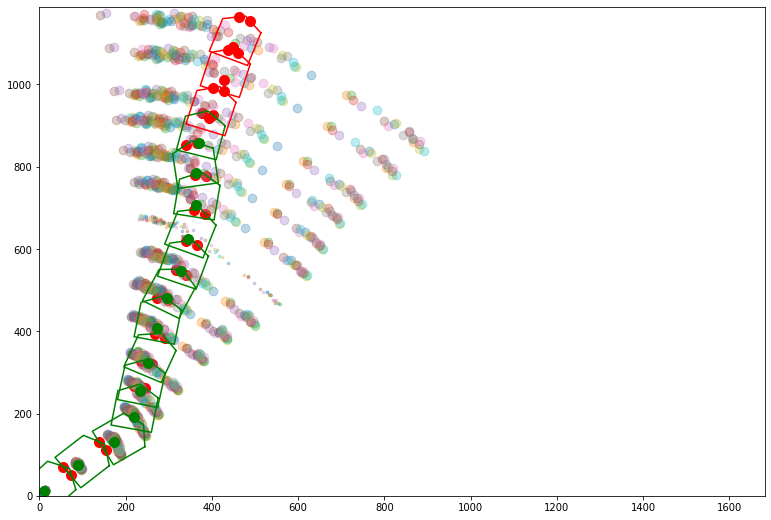

In [94]:
MAX_SPEED = 560
MIN_SPEED = 100
MAX_PROX = 1000
DT = 10
NB_PARTICLES = 100


myPose = Pose(0,0,math.pi/4, isLost=False, nb_particles=NB_PARTICLES)

for i in range(80):
    speed = [random.randrange(MIN_SPEED, MAX_SPEED), random.randrange(MIN_SPEED, MAX_SPEED)]
    prox = expected_prox(myPose.get_coords())
    
    # add noise on the prox
    prox[0] += random.gauss(0, PROX_L_STD)
    prox[1] += random.gauss(0, PROX_R_STD)

    myPose.update(speed, prox, DT)
    
    # plot only 1 on 5 steps
    if i%5 == 0:
        myPose.plot(plot_theta=False, theta_size=5, plot_particles=True)
    
plt.scatter(0, 0, marker='+')
plt.xlim(0, MAP_REAL[0])
plt.ylim(0, MAP_REAL[1])
plt.show()


## Old testing functions
These may not work anymore.


In [6]:
def plot_poses(poses, isLost):
    SCALING_THETAS_PLOT = 5
    # Extracting coordinates
    xs = [poses[i]['x'] for i in range(len(poses))]
    ys = [poses[i]['y'] for i in range(len(poses))]
    thetas = [poses[i]['theta'] for i in range(len(poses))]
    
    # Creating end points to plot thetas
    thetas_dxs = [SCALING_THETAS_PLOT*math.cos(thetas[i]) for i in range(len(poses))]
    thetas_dys = [SCALING_THETAS_PLOT*math.sin(thetas[i]) for i in range(len(poses))]
    
    # Plotting trajectory
    plt.plot(xs, ys, marker='o', color='black')
    plt.scatter(xs[0], ys[0], marker='o', color='cyan', s=150) # start point
    plt.scatter(xs[-1], ys[-1], marker='o', color='green', s=150) # end point
    
    # Plotting thetas arrows
    for i in range(len(poses)):
        plt.arrow(xs[i], ys[i], thetas_dxs[i], thetas_dys[i], color='orange', width=0.1, head_width=1)
    
    # Plotting isLost
    idxs = [index for index, f in enumerate(isLost) if f == True]
    xs_lost = [xs[i] for i in idxs]
    ys_lost = [ys[i] for i in idxs]
    plt.scatter(xs_lost, ys_lost, marker='x', color='red', s=500)
    
    plt.show()
    return

### Particle filter

In [19]:
def plot_path(path, plot_arrow=True):
    SCALING_THETAS_PLOT = 5
    # Extracting coordinates
    xs = [path[i]['x'] for i in range(len(path))]
    ys = [path[i]['y'] for i in range(len(path))]
    thetas = [path[i]['theta'] for i in range(len(path))]
    
    # Creating end points to plot thetas
    thetas_dxs = [SCALING_THETAS_PLOT*math.cos(thetas[i]) for i in range(len(path))]
    thetas_dys = [SCALING_THETAS_PLOT*math.sin(thetas[i]) for i in range(len(path))]
    
    # Plotting trajectory
    plt.plot(xs, ys, marker='o', color='black', alpha=0.1)
    plt.scatter(xs[0], ys[0], marker='o', color='cyan', s=150, alpha=0.4) # start point
    plt.scatter(xs[-1], ys[-1], marker='o', color='green', s=150, alpha=0.4) # end point
    
    # Plotting thetas arrows
    if plot_arrow:
        for i in range(len(path)):
            plt.arrow(xs[i], ys[i], thetas_dxs[i], thetas_dys[i], color='orange', width=0.1, head_width=1)
    
    return


In [172]:
# Initialisation
NB_PARTICLES = 20

particles = []
weights = []

for i in range(NB_PARTICLES):
    myParticle = Particle(0,0,math.pi/2)
    particles.append(myParticle.get_coords())
    weights.append(myParticle.get_weight())

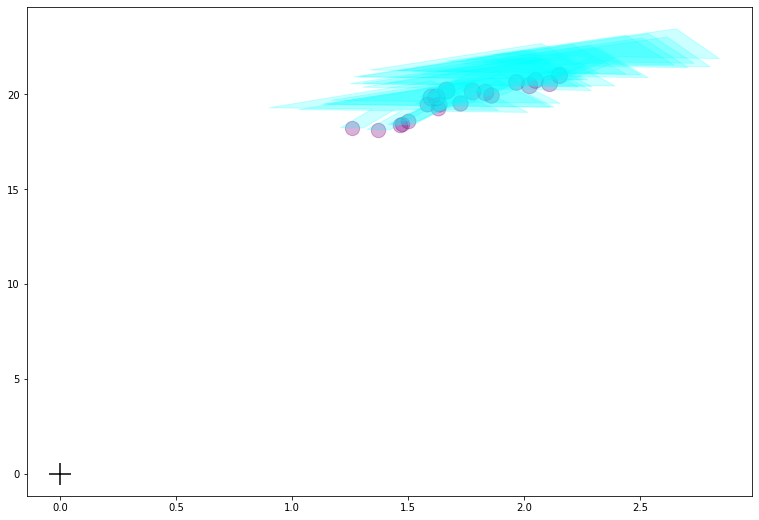

In [173]:
# One step
MAX_SPEED = 560
DT = 10
speed = [random.randrange(0, MAX_SPEED), random.randrange(0, MAX_SPEED)]
prox = [0, 0]

Particle.reset_total_weight()
for i in range(NB_PARTICLES):
    myParticle = Particle(particles[i]['x'], particles[i]['y'], particles[i]['theta'])
    
    myParticle.transition(speed, DT)
    particles[i] = myParticle.get_coords()
    
    myParticle.weight(prox, prox)
    
for i in range(NB_PARTICLES):
    myParticle = Particle(particles[i]['x'], particles[i]['y'], particles[i]['theta'])
    myParticle.normalise_weight()
    weights[i] = myParticle.get_weight()
    
    myParticle.plot(plot_arrow=True)
    
# Resampling the particles
particles = [particles[i] for i in residual_resample(weights)]

    
plt.scatter(0, 0, marker='+', s=500, color='black') # add the origin
plt.show()

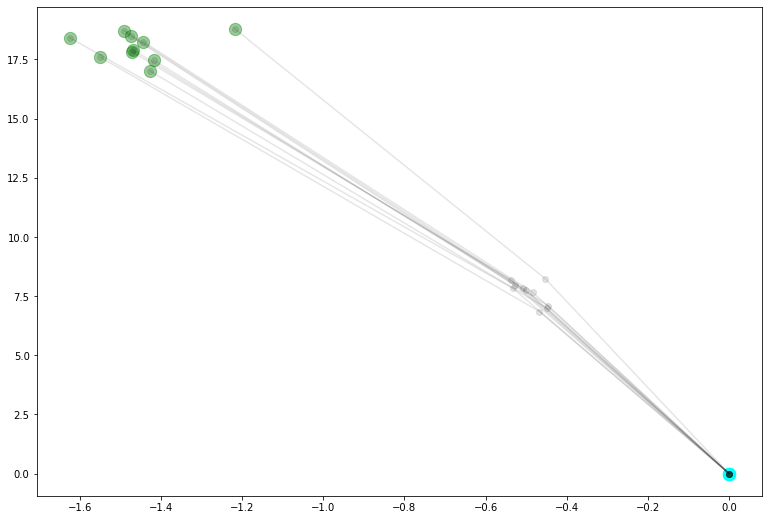

In [52]:
MAX_SPEED = 560
DT = 10
PATH_LENGTH = 3
NB_PARTICLES = 10

VERBOSE_PARTICLE = False

speeds_l = [random.randrange(0, MAX_SPEED) for i in range(PATH_LENGTH)]
speeds_r = [random.randrange(0, MAX_SPEED) for i in range(PATH_LENGTH)]

for j in range(NB_PARTICLES):
    path = []
    myParticle = Particle(0,0,math.pi/2)
    for i in range(PATH_LENGTH):
        # plot_particle(myParticle.get_coords(), plot_arrow=False)
        
        speed = [speeds_l[i], speeds_r[i]]

        path.append(myParticle.get_coords())
        myParticle.transition(speed, DT)
        

    plot_path(path, plot_arrow=False)
    
plt.show()

# Testing on the thymio
This is not implemented for now. IT WILL NOT WORK !

In [104]:
# from tdmclient import ClientAsync
# client = ClientAsync()
# node = await client.wait_for_node()
# await node.lock()

In [105]:
# Ts = 0.1
# gnd_prev = [0, 0]
# SPEED = 50
# 
# def motors(left, right):
#     return {
#         "motor.left.target": [left],
#         "motor.right.target": [right],
#     }
# 
# def on_variables_changed(node, variables):
#     try:
#         gnd = variables["prox.ground.reflected"]
#         d_gnd = gnd-gnd_prev
#         gnd_prev = gnd
#         
#         if d_gnd < -10:
#             node.send_set_variables({'leds.top': [255, 255, 0]})
#         if d_gnd > 10:
#             node.send_set_variables({'leds.top': [0, 0, 255]})            
# 
#     except KeyError:
#         pass  # prox.horizontal not found
# 
# 
# async def prog():
#     await node.watch(variables=True)
#     node.send_set_variables(motors(SPEED, SPEED))
#     node.add_variables_changed_listener(on_variables_changed)
#     await client.sleep()
# client.run_async_program(prog)

In [106]:
# node.send_set_variables(motors(0, 0))
# await node.unlock()